<div style="background-color: #eee3d3">
<h1> 2-missing_value_imputation.ipynb </h1>
</div>

# Missing value imputation with Python

---

### The purpose of this notebook is to use different methods to fill the missing values in our peak table :

- __Univariate__ feature imputation
    - __zero__ (or __one__ or any other constant value to avoid further analytical problems)
    - __mean__
    - __median__
    - __mode__ (most frequent)
    - __minimum__
    - __half minimum__
- __Multivariate__ feature imputation
    - __MICE__ (inspired by the R <code>MICE</code> package)
- __KNN imputation__


These methods come from the scikitlearn documentation : [cf. doc scikitlearn](https://scikit-learn.org/stable/modules/impute.html#marking-imputed-values)

One type of imputation algorithm is __univariate__, which imputes values in the i-th feature dimension __using only non-missing values in that feature dimension__ (e.g. <code>impute.SimpleImputer</code>). By contrast, __multivariate__ imputation algorithms __use the entire set of available feature dimensions__ to estimate the missing values (e.g. <code>impute.IterativeImputer</code>).

---

### The scikitlearn <code>IterativeImputer</code> is still experimental, so we will also use directly the R <code>MICE</code> package ([documentation](https://www.rdocumentation.org/packages/mice/versions/3.13.0/topics/mice)) using the scripts in _bin/missing_value_imputation_ subfolder

---

# Import modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import os
import sys
sys.path.append('/'.join(os.getcwd().split('/')[:-1]) + '/bin/')

from missing_value_imputation_functions import *

# Import data

In [3]:
path_peakTable = '/'.join(os.getcwd().split('/')[:-1]) + '/data/peakTable/original_peak_table/peakTable_HILIC_POS.csv'
peakTable_HILIC_POS = pd.read_csv(path_peakTable, sep=',', decimal='.', na_values='NA')
peakTable_HILIC_POS

,SampleID,Groups,MatchCaseset,TypTumo,CaseHCCWide,variable_3,variable_5,variable_6,variable_7,variable_8,...,variable_2339,variable_2340,variable_2350,variable_2353,variable_2364,variable_2365,variable_2368,variable_2370,variable_2375,variable_2379
0,LivCan_153,Incident,82,HCC,Yes,19.761786,14.635833,22.185582,16.414744,12.615143,...,12.052252,12.568647,13.192848,13.230752,12.248590,12.114328,14.269258,12.355017,13.114289,13.882526
1,LivCan_154,Non-case,82,NaN,No,19.735279,15.193396,20.831414,15.052533,NaN,...,13.020365,12.928643,13.697314,NaN,12.604052,NaN,NaN,12.208084,NaN,NaN
2,LivCan_267,Incident,427,HCC,Yes,19.116076,15.446714,22.152604,16.410827,NaN,...,NaN,NaN,NaN,13.330175,NaN,NaN,14.215988,NaN,12.955618,13.778398
3,LivCan_268,Non-case,427,NaN,No,19.376875,15.460525,22.169389,16.403964,12.720767,...,NaN,NaN,13.086805,13.304171,NaN,11.605353,14.284148,12.319119,13.058285,13.812829
4,LivCan_299,Incident,376,HCC_Wide,Yes,19.555938,14.515536,22.150249,16.372219,12.314019,...,NaN,NaN,NaN,13.306722,12.349830,11.926237,14.192775,NaN,13.006556,13.841201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,LivCan_080,Non-case,56,NaN,No,19.664978,14.447858,20.808503,15.027154,12.648327,...,12.349299,11.505004,13.189121,NaN,NaN,NaN,NaN,NaN,NaN,NaN
182,LivCan_375,Incident,383,HCC,Yes,19.301954,14.839941,21.085175,15.321075,12.510670,...,12.909283,12.642143,NaN,NaN,12.708850,12.462751,12.175110,12.635066,NaN,NaN
183,LivCan_376,Non-case,383,NaN,No,19.170626,14.291711,21.381912,15.197205,12.499558,...,12.846355,13.243400,NaN,NaN,12.199647,NaN,NaN,12.258149,NaN,NaN
184,LivCan_165,Incident,147,HCC,Yes,18.869505,14.440576,20.961485,14.829978,12.312338,...,12.477753,11.789382,NaN,NaN,11.628154,NaN,NaN,NaN,NaN,NaN


In [4]:
X = peakTable_HILIC_POS.iloc[:, ['variable' in col for col in peakTable_HILIC_POS.columns]]
X

,variable_3,variable_5,variable_6,variable_7,variable_8,variable_10,variable_11,variable_14,variable_22,variable_23,...,variable_2339,variable_2340,variable_2350,variable_2353,variable_2364,variable_2365,variable_2368,variable_2370,variable_2375,variable_2379
0,19.761786,14.635833,22.185582,16.414744,12.615143,15.580604,15.881437,17.500899,12.792893,16.805604,...,12.052252,12.568647,13.192848,13.230752,12.248590,12.114328,14.269258,12.355017,13.114289,13.882526
1,19.735279,15.193396,20.831414,15.052533,NaN,15.145423,14.034654,17.953780,NaN,15.907714,...,13.020365,12.928643,13.697314,NaN,12.604052,NaN,NaN,12.208084,NaN,NaN
2,19.116076,15.446714,22.152604,16.410827,NaN,14.628890,15.316772,17.404715,12.786407,15.947176,...,NaN,NaN,NaN,13.330175,NaN,NaN,14.215988,NaN,12.955618,13.778398
3,19.376875,15.460525,22.169389,16.403964,12.720767,15.937169,15.967749,15.836957,NaN,16.371211,...,NaN,NaN,13.086805,13.304171,NaN,11.605353,14.284148,12.319119,13.058285,13.812829
4,19.555938,14.515536,22.150249,16.372219,12.314019,14.950203,15.294906,16.610171,12.214057,16.171763,...,NaN,NaN,NaN,13.306722,12.349830,11.926237,14.192775,NaN,13.006556,13.841201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,19.664978,14.447858,20.808503,15.027154,12.648327,14.806952,14.244917,17.126579,12.080710,15.388376,...,12.349299,11.505004,13.189121,NaN,NaN,NaN,NaN,NaN,NaN,NaN
182,19.301954,14.839941,21.085175,15.321075,12.510670,14.488147,15.163197,16.816591,12.452644,16.474456,...,12.909283,12.642143,NaN,NaN,12.708850,12.462751,12.175110,12.635066,NaN,NaN
183,19.170626,14.291711,21.381912,15.197205,12.499558,14.434959,14.520558,16.315887,12.808417,15.613263,...,12.846355,13.243400,NaN,NaN,12.199647,NaN,NaN,12.258149,NaN,NaN
184,18.869505,14.440576,20.961485,14.829978,12.312338,14.114074,13.776358,16.110117,12.667428,16.021372,...,12.477753,11.789382,NaN,NaN,11.628154,NaN,NaN,NaN,NaN,NaN


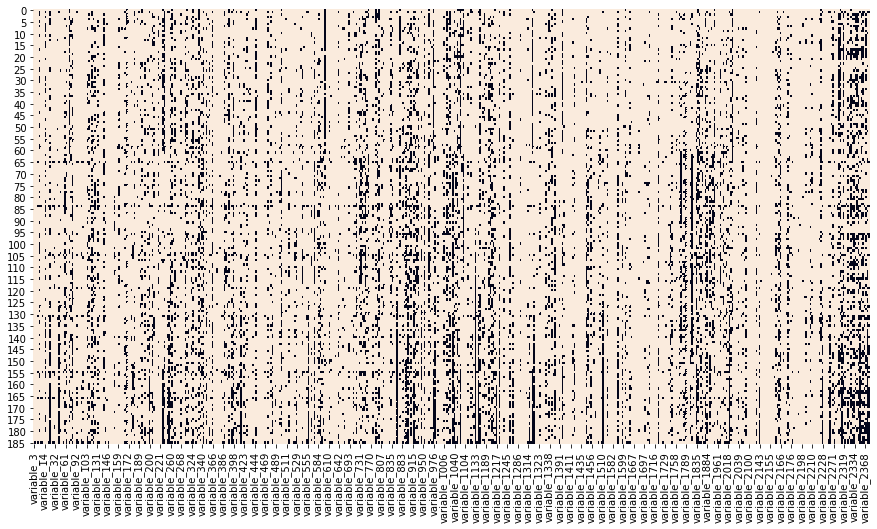

In [5]:
plt.figure(figsize=(15,8))
sns.heatmap(X.notna(), cbar=False)
plt.show()

The dark points indicate a missing value in the peak table

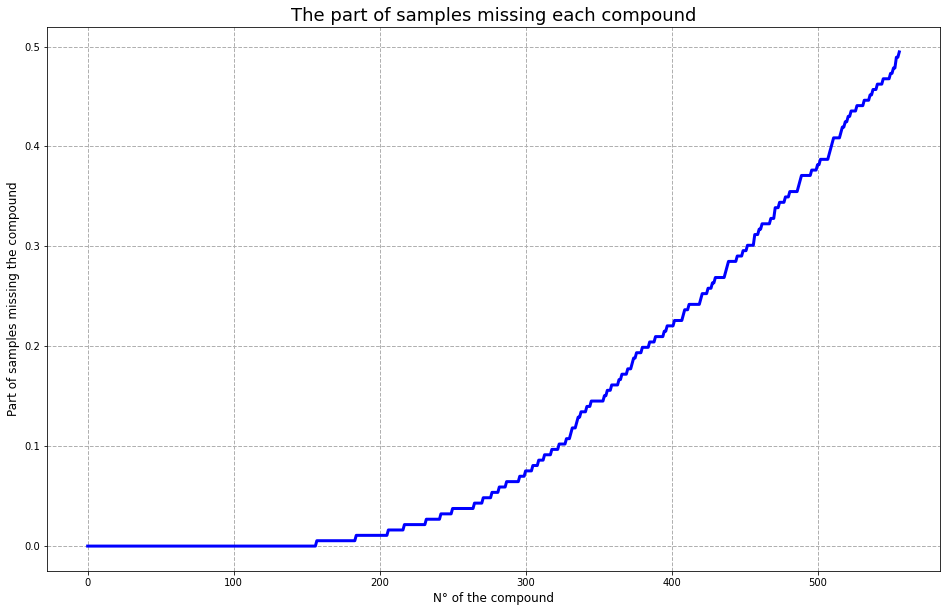

In [6]:
plt.figure(figsize=(16,10))
plt.plot((X.isna().sum() / X.shape[0]).sort_values().values, color='b', linewidth=3)
plt.xlabel('N° of the compound', fontsize=12)
plt.ylabel('Part of samples missing the compound', fontsize=12)
plt.title('The part of samples missing each compound', fontsize=18)
plt.grid(linestyle='--', linewidth=1)
plt.show()

# Path to save imputed peak tables

In [7]:
path_peakTable_imputed = '/'.join(os.getcwd().split('/')[:-1]) + '/data/peakTable/imputed_peak_tables/'

# Univariate feature imputation

## Constant imputation (with whatever constant value passed as argument)

All missing values in the peak table will be replaced by the constant value you pass as parameter.

In [8]:
X_const_0 = const_imputer(X)
X_const_0
X_const_0.to_csv(path_peakTable_imputed + 'X_const_0.csv', index = False, header=True)

In [9]:
X_const_1 = const_imputer(X, 1)
X_const_1
X_const_1.to_csv(path_peakTable_imputed + 'X_const_1.csv', index = False, header=True)

## Mean imputation

For each feature, the missing values are imputed by the mean value of the non-missing values in that feature.

In [10]:
X_mean = mean_imputer(X)
X_mean
X_mean.to_csv(path_peakTable_imputed + 'X_mean.csv', index = False, header=True)

## Median imputation

For each feature, the missing values are imputed by the median value of the non-missing values in that feature.

In [11]:
X_median = median_imputer(X)
X_median
X_median.to_csv(path_peakTable_imputed + 'X_median.csv', index = False, header=True)

## Mode imputation (most frequent)

For each feature, the missing values are imputed by the most frequent value (rounded at 1.e-2) of the non-missing values in that feature.

In [12]:
X_most = mode_imputer(X)
X_most
X_most.to_csv(path_peakTable_imputed + 'X_most.csv', index = False, header=True)

## Imputation with minimum value of the feature

For each feature, the missing values are imputed by the minimum value of the non-missing values in that feature.

In [13]:
X_min_f = min_imputer(X)
X_min_f
X_min_f.to_csv(path_peakTable_imputed + 'X_min_f.csv', index = False, header=True)

### imputation with half minimum value of the feature

For each feature, the missing values are imputed by the half of the minimum value of the non-missing values in that feature.

In [14]:
X_half_min_f = half_min_imputer(X)
X_half_min_f
X_half_min_f.to_csv(path_peakTable_imputed + 'X_half_min_f.csv', index = False, header=True)

# Multivariate feature imputation

[cf. doc scikitlearn IterativeImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html#sklearn.impute.IterativeImputer)

<code>IterativeImputer</code> was inspired by the R MICE package (Multivariate Imputation by Chained Equations).

On this page ([link](https://scikit-learn.org/stable/auto_examples/impute/plot_iterative_imputer_variants_comparison.html)) are presented the different possible estimators that can be applied with <code>IterativeImputer</code> :
- <code>BayesianRidge</code> : regularized linear regression
- <code>DecisionTreeRegressor</code> : non-linear regression
- <code>ExtraTreesRegressor</code> : similar to missForest in R
- <code>KNeighborsRegressor</code> : comparable to other KNN imputation approaches


In [15]:
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor

In [16]:
estimators = [
    BayesianRidge(),
    DecisionTreeRegressor(max_features='sqrt', random_state=0),
    ExtraTreesRegressor(n_estimators=10, random_state=0),
    KNeighborsRegressor(n_neighbors=15)
]

In [17]:
for estimator in estimators:
    
    X_python_MICE = python_MICE_imputer(X, estimator)
    
    X_python_MICE.to_csv(path_peakTable_imputed + 'X_python_MICE_' + str(estimator).split('(')[0] + '.csv', index = False, header=True)

/home/vincentm/.local/lib/python3.6/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


----- 7.4 seconds -----


/home/vincentm/.local/lib/python3.6/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


----- 6.9 seconds -----


/home/vincentm/.local/lib/python3.6/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


----- 63.5 seconds -----


/home/vincentm/.local/lib/python3.6/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


----- 8.4 seconds -----


## Nearest neighbors imputation

According to scikit-learn documentation (https://scikit-learn.org/stable/modules/impute.html#nearest-neighbors-imputation), "Each missing feature is imputed using values from n_neighbors nearest neighbors that have a value for the feature. The feature of the neighbors are averaged uniformly or weighted by distance to each neighbor. If a sample has more than one feature missing, then the neighbors for that sample can be different depending on the particular feature being imputed."

We let the possibility for the user to impute the values along the two axis with the parameter 'by' :
- by='samples' (default) : the missing value for a specific feature in a sample is imputed using the values of that feature in the n_neighbors samples which have a non-missing value for that feature
- by='feature' : the missing value for a specific feature in a sample is imputed using the values of the n_neighbors features in that sample which have a non-missing value for that sample

In [18]:
X_KNN_features = KNN_imputer(X, by='features')
X_KNN_features.columns = X.columns
X_KNN_features.to_csv(path_peakTable_imputed + 'X_KNN_features.csv', index=False, header=True)

In [19]:
X_KNN_samples = KNN_imputer(X, by='samples')
X_KNN_samples.columns = X.columns
X_KNN_samples.to_csv(path_peakTable_imputed + 'X_KNN_samples.csv', index=False, header=True)

---
# Missing value imputation using R MICE package

Here is a link where the [MICE algorithm is explained](https://cran.r-project.org/web/packages/miceRanger/vignettes/miceAlgorithm.html).

The MICE (Multivariate Imputation by Chained Equations) algorithm is a multivariate method to impute missing values. Each missing value is imputed using a separate model with the other variables in the dataset. Iterations should be run until it appears that convergence has been met. The computational time can be huge, thus we proceed in four steps :
- using the <code>quickpred</code> function ([documentation](https://cran.r-project.org/web/packages/mice/mice.pdf#Rfn.quickpred.1)), we create a squared (column number of the peak table) binary matrix (<code>predictorMatrix</code>), in which $\mathcal{M}_{i,j} = 1$ if we can use the variable $j$ to impute the missing values of the variable $i$, $\mathcal{M}_{i,j} = 0$ otherwise. With this step, only the variables which have a given minimum correlation value can be used to impute the missing values, thus reducing the computational time.
- using the <code>mice</code> function ([documentation](https://cran.r-project.org/web/packages/mice/mice.pdf#Rfn.mice.1)), we actually run the missing value imputation. The built-in imputation methods are listed in the documentation. As we have numerical values in our peak table, we will only implement the following methods in the R script :
    - __Mean__ (method = 'mean')
    - __Simple random sampling__ (method = 'sample')
    - __Classification and regression trees__ (method = 'cart')
    - __Regression imputation__ (classified into two different versions: deterministic and stochastic regression imputation) :
        - __Bayesian linear regression__ (method = "norm")
        - __Deterministic regression imputation__ (method = "norm.predict") :
            - replaces missing values with the exact prediction of the regression model. Random variation (i.e. an error term) around the regression slope is not considered. Imputed values are therefore often too precise and lead to an overestimation of the correlation between X and Y.
        - __Stochastic regression imputation__ (method = "norm.nob") :
            - was developed in order to solve this issue of deterministic regression imputation. Stochastic regression imputation adds a random error term to the predicted value and is therefore able to reproduce the correlation of X and Y more appropriately.
    - __Predictive mean matching__ (method = "pmm") :
        - Overcome disadvantages of regression imputation, implausible values (e.g. negative incomes) and problems with heteroscedastic data

- using the <code>merge_imputations</code> method, we merge the multiple imputed dataframes into one single dataframe (mean of the multiple dataframes)
- using the <code>write.csv</code> method, we export the imputed data into a separate csv file
---

In [20]:
# Set working directory
pathWorkDir = '/'.join(os.getcwd().split('/')[:-1])

# Set path to slurm script, R script, data and output
path2Rscript = pathWorkDir + '/bin/missing_value_imputation/mv_imp_MICE.R'
path2peakTable = pathWorkDir + '/data/peakTable/original_peak_table/peakTable_HILIC_POS.csv'
path2output = pathWorkDir + '/data/peakTable/imputed_peak_tables'
list_methods = 'c("mean","sample","pmm","cart","norm","norm.nob","norm.predict")' # all these methods should work
list_methods = "'".join(['', list_methods, ''])

# Launch missing value imputation with R

## By launching the R script

In [21]:
! Rscript $path2Rscript $path2peakTable $path2output $list_methods

[1] "/home/vincentm/INSA_Course/project/data/peakTable/original_peak_table/peakTable_HILIC_POS.csv"
[1] "/home/vincentm/INSA_Course/project/data/peakTable/imputed_peak_tables"
[1] "c(\"mean\",\"sample\",\"pmm\",\"cart\",\"norm\",\"norm.nob\",\"norm.predict\")"
[1] "mean"         "sample"       "pmm"          "cart"         "norm"        
[6] "norm.nob"     "norm.predict"
Loading required package: mice

Attaching package: ‘mice’

The following object is masked from ‘package:stats’:

    filter

The following objects are masked from ‘package:base’:

    cbind, rbind

Loading required package: sjmisc
----------------------------------------------------------------------------------------------------
----------------------------------------------- mean -----------------------------------------------
...Computing...
...............
2 min 51 sec
----------------------------------------------------------------------------------------------------



--------------------------------------------

### EXERCISE : comment the imputations

Create one or several functions to __assess the imputation quality for each method used__.

It could be interesting to find a __quantitative criterion__ and a __graphic representation__ to compare the quality of imputations.

_Hint : a good imputation method should not change too much the distribution of feature values_-based Normalisation Methods

Based on your criterion and graphic outputs, which method(s) should be used on these data ?

What are the common missing value imputation methods used in metabolomics (on LC-MS data in particular) ? Does it correspond to the "best" method(s) you found here ?